In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

In [2]:
df = pd.read_excel("../data/default of credit card clients.xls", header = 1)

df = df.rename(columns={'default payment next month': 'DEFAULT'})
df['EDUCATION'] = df['EDUCATION'].replace([5],4) ##5 and 6 are also others which is what 4 is
df['EDUCATION'] = df['EDUCATION'].replace([6],4)
X = df.drop(columns = ['DEFAULT','ID'])
y= df['DEFAULT']


In [3]:
onehot_ftrs = ['SEX','EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2' ,'PAY_3', 'PAY_4','PAY_5','PAY_6']
minmax_ftrs = ['AGE']
std_ftrs = ['LIMIT_BAL','BILL_AMT1','BILL_AMT2' ,'BILL_AMT3','BILL_AMT4','BILL_AMT5' ,'BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3' ,'PAY_AMT4' ,'PAY_AMT5' ,'PAY_AMT6']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

prep = Pipeline(steps=[('preprocessor', preprocessor)])

In [4]:

def RF_f1(X, y, prep, param_grid):
    '''
    This function splits the data to train/val/test using stratified split
    Gets best params using val
    trains model
    Gets test score 
    For 5 dif random states
    '''
    nr_states = 5
    test_scores = np.zeros(nr_states)
    best_models = []
    
    ##Split
    for i in range(nr_states):
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=37*i)
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=37*i)

        X_train_prep = prep.fit_transform(X_train)
        X_val_prep = prep.transform(X_val)
        X_test_prep = prep.transform(X_test)
        train_score = np.zeros(len(ParameterGrid(param_grid)))
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p] 
            clf = RandomForestClassifier(**params,random_state = 37*i,n_jobs=-1) # initialize the classifier
            clf.fit(X_train_prep,y_train) # fit the model
            models.append(clf) 
        # calculate train and validation fbeta scores
            y_train_pred = clf.predict(X_train_prep)
            train_score[p] = fbeta_score(y_train,y_train_pred, beta = 1)
            y_val_pred = clf.predict(X_val_prep)
            val_score[p] = fbeta_score(y_val,y_val_pred, beta = 1)
    
    # collect and save the best model
        best_models.append(models[np.argmax(val_score)])
    #calculate and save the test score
        y_test_pred = best_models[-1].predict(X_test_prep)
        test_scores[i] = fbeta_score(y_test,y_test_pred,beta=1)
    return best_models, test_scores


In [6]:
##baseline f1 is 0.362296
param_grid = {
              'min_samples_leaf' : [1,2,5,10],
              'max_depth': [1, 3, 10, 30, 100], # the max_depth should be smaller or equal than the number of features roughly
              'max_features': [0.5,0.75,1.0] # linearly spaced between 0.5 and 1
              } 
rf_bestmodels, rf_test_scores = RF_f1(X, y, prep, param_grid)

In [7]:
rf_test_scores

array([0.44950495, 0.46461689, 0.47103877, 0.4691358 , 0.48390244])

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def LogReg_f1(X, y, prep, param_grid, penalty):
    '''
    This function splits the data to train/val/test using stratified split
    Gets best params using val
    trains model
    Gets test score 
    For 5 dif random states
    '''
    nr_states = 5
    test_scores = np.zeros(nr_states)
    best_models = []
    
    ##Split
    for i in range(nr_states):
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=37*i)
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=37*i)

        X_train_prep = prep.fit_transform(X_train)
        X_val_prep = prep.transform(X_val)
        X_test_prep = prep.transform(X_test)
        train_score = np.zeros(len(ParameterGrid(param_grid)))
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p] 
            clf = LogisticRegression(**params,penalty = penalty, random_state = 37*i,n_jobs=-1,solver = 'saga',max_iter = 100000) # initialize the classifier
            clf.fit(X_train_prep,y_train) # fit the model
            models.append(clf) 
        # calculate train and validation fbeta scores
            y_train_pred = clf.predict(X_train_prep)
            train_score[p] = fbeta_score(y_train,y_train_pred, beta = 1)
            y_val_pred = clf.predict(X_val_prep)
            val_score[p] = fbeta_score(y_val,y_val_pred, beta = 1)
    
    # collect and save the best model
        best_models.append(models[np.argmax(val_score)])
    # calculate and save the test score
        y_test_pred = best_models[-1].predict(X_test_prep)
        test_scores[i] = fbeta_score(y_test,y_test_pred, beta = 1)
    return best_models, test_scores


In [9]:
param_grid = {
              'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}
l1_bestmodels, l1_test_scores = LogReg_f1(X, y, prep, param_grid, 'l1')

In [10]:
l1_test_scores

array([0.44095286, 0.4501992 , 0.478389  , 0.45708681, 0.46683292])

In [11]:
param_grid = {
              'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
}
l2_bestmodels, l2_test_scores = LogReg_f1(X, y, prep, param_grid, 'l2')

In [12]:
l2_test_scores

array([0.44196655, 0.44897959, 0.4771274 , 0.45837414, 0.46859422])

In [13]:
param_grid = {
              'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
            'l1_ratio': [0.01, 0.1, 0.25, 0.5,0.75, 0.9, 0.99]
}
elasticnet_bestmodels, elasticnet_test_scores = LogReg_f1(X, y, prep, param_grid, 'elasticnet')

In [14]:
elasticnet_test_scores

array([0.44196655, 0.4501992 , 0.47590954, 0.45383104, 0.46859422])

In [58]:
from sklearn.neighbors import KNeighborsClassifier
def KN_f1(X, y, prep, param_grid):
    '''
    This function splits the data to train/val/test using stratified split
    Gets best params using val
    trains model
    Gets test score 
    For 5 dif random states
    '''
    nr_states = 5
    test_scores = np.zeros(nr_states)
    best_models = []
    
    ##Split
    for i in range(nr_states):
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=37*i)
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=37*i)

        X_train_prep = prep.fit_transform(X_train)
        X_val_prep = prep.transform(X_val)
        X_test_prep = prep.transform(X_test)
        train_score = np.zeros(len(ParameterGrid(param_grid)))
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p] 
            clf = KNeighborsClassifier(**params,n_jobs=-1) # initialize the classifier
            clf.fit(X_train_prep,y_train) # fit the model
            models.append(clf) 
        # calculate train and validation fbeta scores
            y_train_pred = clf.predict(X_train_prep)
            train_score[p] = fbeta_score(y_train,y_train_pred, beta = 1)
            y_val_pred = clf.predict(X_val_prep)
            val_score[p] = fbeta_score(y_val,y_val_pred, beta = 1)
    
    # collect and save the best model
        best_models.append(models[np.argmax(val_score)])
    #calculate and save the test score
        y_test_pred = best_models[-1].predict(X_test_prep)
        test_scores[i] = fbeta_score(y_test,y_test_pred,beta=1)
    return best_models, test_scores


In [59]:
param_grid = {
              'n_neighbors': [3, 10, 30, 100], 
              'weights':['uniform','distance']
              } 
knn_bestmodels, knn_test_scores = KN_f1(X, y, prep, param_grid)

In [60]:
knn_test_scores

array([0.41658537, 0.42367906, 0.41894531, 0.42569511, 0.43179588])

In [90]:
import xgboost
def xgb_f1(X, y, prep, param_grid):
    '''
    This function splits the data to train/val/test using stratified split
    Gets best params using val
    trains model
    Gets test score 
    For 5 dif random states
    '''
    nr_states = 5
    test_scores = np.zeros(nr_states)
    best_models = []
    
    ##Split
    for i in range(nr_states):
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=37*i)
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=37*i)

        X_train_prep = prep.fit_transform(X_train)
        X_val_prep = prep.transform(X_val)
        X_test_prep = prep.transform(X_test)
        train_score = np.zeros(len(ParameterGrid(param_grid)))
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []
        for p in range(len(ParameterGrid(param_grid))):
            XGB = xgboost.XGBClassifier()
            XGB.set_params(**ParameterGrid(param_grid)[p],objective = 'binary:hinge',random_state = 37*i)
            XGB.fit(X_train_prep,y_train,early_stopping_rounds=50,eval_set=[(X_val_prep, y_val)], verbose=False, eval_metric = 'auc')
            y_val_pred = XGB.predict(X_val_prep)
            val_score[p] = fbeta_score(y_val,y_val_pred,beta=1)
            models.append(XGB)
    # collect and save the best model
        best_models.append(models[np.argmax(val_score)])
    #calculate and save the test score
        y_test_pred = best_models[-1].predict(X_test_prep)
        test_scores[i] = fbeta_score(y_test,y_test_pred,beta=1)
    return best_models, test_scores


In [91]:
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [1354],
              "reg_alpha": [0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              #"reg_lambda": [0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              #"missing": [np.nan], 
              "max_depth": [1,3,10,30,100],
              "colsample_bytree": [0.5, 0.7,0.9],              
              "subsample": [0.5, 0.66, 0.75, 1]}

In [92]:
xgb_bestmodels, xgb_test_scores = xgb_f1(X, y, prep, param_grid)

In [93]:
xgb_test_scores

array([0.5158371 , 0.53190755, 0.53474837, 0.53266998, 0.54961295])

In [ ]:
xgb_bestmodels

In [78]:
means = [rf_test_scores.mean(), l1_test_scores.mean(), l2_test_scores.mean(), elasticnet_test_scores.mean(),knn_test_scores.mean(),xgb_test_scores.mean()]
sds = [rf_test_scores.std(), l1_test_scores.std(), l2_test_scores.std(), elasticnet_test_scores.std(),knn_test_scores.std(),xgb_test_scores.std()]
names = ['RF', 'L1', 'L2', 'Elastic','KNN','XGB' ]
xpos = np.arange(len(names))

[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=30,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=4, num_parallel_tree=1,
              objective='binary:hinge', random_state=1354, reg_alpha=0.1,
              reg_lambda=1, scale_pos_weight=3.5454545454545454, seed=1354,
              subsample=0.66, tree_method='exact', validate_parameters=1,
              verbosity=None)]

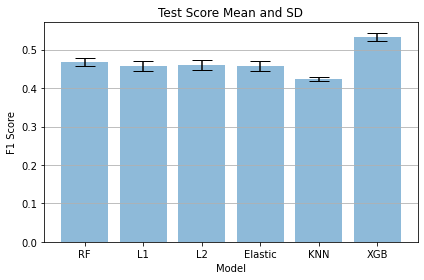

In [89]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(xpos, means, yerr=sds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('F1 Score')
ax.set_xticks(xpos)
ax.set_xlabel('Model')
ax.set_xticklabels(names)
ax.set_title('Test Score Mean and SD')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('../figures/model_comparison.png', dpi=300, format='png')